### useful functions

In [1]:
import scipy.io as scio
import numpy as np
import pywt
from scipy import signal
from matplotlib import pylab
from pylab import *

C:\Users\morta\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def spikedet(signal, threshold):
    detection = []
    for id in range(len(signal)):
        if signal[id] > threshold:
            detection.append(id)
    return detection


def neofilter(v,t):
    neo_value = [0 for _ in range(len(t))]
    peaks = []
    #neo calculation
    for i in range(1,len(t)-1):
        neo_value[i] = v[i]*v[i] - v[i-1]*v[i+1]
    neo_value[0] = neo_value[1]
    neo_value[-1] = neo_value[-2]
    return neo_value

def spikefilter(peaks,strip):
    x = np.array(peaks)
    len_old = x.shape[0]
    for i in range(len_old):
        if i >= x.shape[0] - 1:
            break
        for j in range(strip):#11
            if i >= x.shape[0] - 1:
                break
            if (x[i+1] - x[i]) < strip:#原来10，24k
            #if (x[i+1] - x[i]) < 6: #for DWT
                x = np.delete(x,i+1)
    return x

def dacalculation(groundtruth,detection):
    TP = FP = FN = 0
    misalignment = 0
    i = j = 0
    while((i<len(groundtruth)) & (j < len(detection))):
        if (detection[j] - groundtruth[i] <= 26) & ((detection[j] - groundtruth[i]) >= 0) : #detection succeeds, true positive, pointer both increases
            TP += 1
            misalignment += detection[j] - groundtruth[i]
            i += 1
            j +=1
        elif(detection[j] - groundtruth[i]) > 26: #a spike is missed, false negtive, only ground truth pointer increase
            FN +=1
            i += 1
        else: #noise is detected, false positive, pointer of detection increase
            FP += 1
            j += 1

    FN = FN + (len(groundtruth) - i)
    FP = FP + (len(detection) - j)
    miss = misalignment/TP
    DA = TP/(TP+FN+FP)
    
#     print("TP,FN,FP,DA:")
#     print(TP,FN,FP,DA)
    return DA,miss

def smoothing(datain,t):
    window = signal.windows.boxcar(5)
    smooth = [0 for _ in range(len(t))]
    for i in range(2,len(t)-2):
        smooth[i] = window[0] * datain[i-2] + window[1] * datain[i-1]+ window[2] * datain[i]+ window[3] * datain[i+1]+ window[4] * datain[i+2]
    smooth[0] = window[2] * datain[0] + window[3] * datain[1]+ window[4] * datain[2]
    smooth[1] = window[1] * datain[0] + window[2] * datain[1] + window[3] * datain[2]+ window[4] * datain[3]
    smooth[-1] = window[0] * datain[-3] + window[1] * datain[-2]+ window[2] * datain[-1]
    smooth[-2] = window[0] * datain[-4] + window[1] * datain[-3] + window[2] * datain[-2]+ window[3] * datain[-1]
    
    return np.array(smooth)


In [3]:
def sigma_calculation(v,sigma_a, G, T):
    #values = []
    num = 0
    ratio = 0
    #sigma_a = 0.5 #initial number, not sure the set value
    sigma_t = 0.3173
#     for t,y in v:
#         values.append(y)
#     std = np.std(values)
    for y in v:
        if abs(y) > sigma_a:
            num += 1
    ratio = num/len(v)
    error = ratio - sigma_t
    new_sigma_a = sigma_a + G * T * error
    return new_sigma_a

# Prepare Dataset

In [6]:
names = locals()
for w in ['005','01','015','02']:
    names['dataFile_e2'+str(w)] = '.\Simulator\C_Easy2_noise'+ str(w)+'.mat'
    names['dataFile_e1'+str(w)] = '.\Simulator\C_Easy1_noise'+ str(w)+'.mat'
    names['dataFile_d1'+str(w)] = '.\Simulator\C_Difficult1_noise'+ str(w)+'.mat'
    names['dataFile_d2'+str(w)] = '.\Simulator\C_Difficult2_noise'+ str(w)+'.mat'# path is needed to be changed
    names['data_e1'+str(w)],names['data_e2'+str(w)],names['data_d1'+str(w)],names['data_d2'+str(w)] = scio.loadmat(names['dataFile_e1'+str(w)]),scio.loadmat(names['dataFile_e2'+str(w)]),scio.loadmat(names['dataFile_d1'+str(w)]),scio.loadmat(names['dataFile_d2'+str(w)])
    names['spikes_e1'+str(w)],names['spikes_e2'+str(w)],names['spikes_d1'+str(w)],names['spikes_d2'+str(w)] =  names['data_e1'+str(w)]['data'][0], names['data_e2'+str(w)]['data'][0],names['data_d1'+str(w)]['data'][0],names['data_d2'+str(w)]['data'][0]
    names['index_e1'+str(w)] = names['index_e2'+str(w)] = names['index_d1'+str(w)] = names['index_d2'+str(w)] = np.array(range(len(names['spikes_e2'+str(w)])))
    for i in ['_e1','_e2','_d1','_d2']:
        names['min'+str(i)+str(w)],names['max'+str(i)+str(w)] = names['spikes'+str(i)+str(w)].min(), names['spikes'+str(i)+str(w)].max()
        names['maxvalue'+str(i)+str(w)] = max(abs(names['min'+str(i)+str(w)]),names['max'+str(i)+str(w)])
        names['spikes_nor'+str(i)+str(w)] = (names['spikes'+str(i)+str(w)])/names['maxvalue'+str(i)+str(w)]

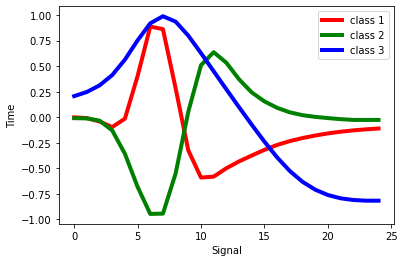

In [9]:
data_e1005['data']
spike_times = data_e1005['spike_times'][0][0][0]
signals = list(map(lambda x: data_e1005['data'][0][x+15:x+40],spike_times))
gt = data_e1005['spike_class'][0][0][0]
values= []
types = [[],[],[]]
for i,sig in enumerate(signals):
    values.append((np.append(feature_extraction(sig,1),gt[i])))
    types[gt[i]-1].append(sig)
means=[]
for i in range(3):
    plt.plot(range(len(types[i][0])),np.mean(types[i],axis=0),c='rgbk'[i], label='class '+str(i+1),linewidth='4')
    means.append(np.append(feature_extraction(np.mean(types[i],axis=0),1),i+1))
means
plt.xlabel('Signal')
plt.ylabel('Time')
plt.legend()
plt.savefig('signalSpace.png',dpi=400, transparent=True)
plt.legend()

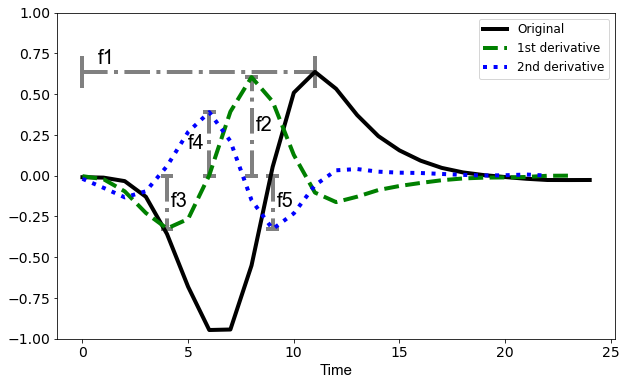

In [20]:
plt.figure(figsize=(10,6))
signal0= np.mean(types[1],axis=0)
plt.plot(range(len(signal0)),signal0,c='rgbk'[3], label='Original',linewidth='4')
plt.xlabel('Time',fontsize=15,fontname="Arial")

fd = np.diff(signal0)
sd = np.diff(fd)
plt.plot(np.arange(len(fd)),fd,'--',c='rgbk'[1], label='1st derivative',linewidth='4')
plt.plot(np.arange(len(sd)),sd,':',c='rgbk'[2], label='2nd derivative',linewidth='4')
plt.vlines(np.argmax(signal0),max(signal0)-0.1,max(signal0)+0.10,color='grey',linewidth=4)
plt.vlines(0,max(signal0)-0.1,max(signal0)+0.10,color='grey',linewidth=4)
plt.hlines(max(signal0),0,argmax(signal0),color='grey',linestyles='dashdot',linewidth=4)
plt.text(0.75,max(signal0)+0.05,'f1', fontsize=20, color='black',fontname="Arial")

plt.hlines(max(fd),np.argmax(fd)-0.3,argmax(fd)+0.3,color='grey',linewidth=4)
plt.hlines(0,np.argmax(fd)-0.3,argmax(fd)+0.3,color='grey',linewidth=4)
plt.vlines(np.argmax(fd),0,max(fd),color='grey',linestyles='dashdot',linewidth=4)
plt.text(np.argmax(fd)+0.2,max(fd)/2-0.03,'f2', fontsize=20, color='black',fontname="Arial")

plt.hlines(min(fd),np.argmin(fd)-0.3,argmin(fd)+0.3,color='grey',linewidth=4)
plt.hlines(0,np.argmin(fd)-0.3,argmin(fd)+0.3,color='grey',linewidth=4)
plt.vlines(np.argmin(fd),0,min(fd),color='grey',linestyles='dashdot',linewidth=4)
plt.text(np.argmin(fd)+0.2,min(fd)/2-0.03,'f3', fontsize=20, color='black',fontname="Arial")

plt.hlines(max(sd),np.argmax(sd)-0.3,argmax(sd)+0.3,color='grey',linewidth=4)
plt.hlines(0,np.argmax(sd)-0.3,argmax(sd)+0.3,color='grey',linewidth=4)
plt.vlines(np.argmax(sd),0,max(sd),color='grey',linestyles='dashdot',linewidth=4)
plt.text(np.argmax(sd)-1,max(sd)/2-0.03,'f4', fontsize=20, color='black',fontname="Arial")


plt.hlines(min(sd),np.argmin(sd)-0.3,argmin(sd)+0.3,color='grey',linewidth=4)
plt.hlines(0,np.argmin(sd)-0.3,argmin(sd)+0.3,color='grey',linewidth=4)
plt.vlines(np.argmin(sd),0,min(sd),color='grey',linestyles='dashdot',linewidth=4)
plt.text(np.argmin(sd)+0.2,min(sd)/2-0.03,'f5', fontsize=20, color='black',fontname="Arial")

plt.yticks(size = 14)
plt.xticks(size = 14)
plt.ylim(-1,1)
plt.legend(fontsize=12)
plt.savefig('featureSelection.png',dpi=400,bbox_inches = 'tight')


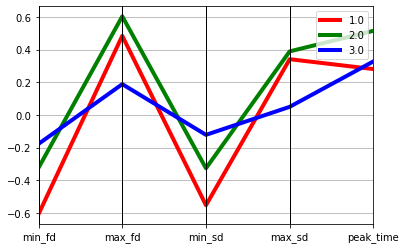

In [27]:
import pandas as pd
features = pd.DataFrame(means,columns=['min_fd','max_fd','min_sd','max_sd','peak_time','type'])
from pandas.plotting import parallel_coordinates
x = parallel_coordinates(features, 'type',color=['red','green','blue'],linewidth='4')
plt.savefig('featureSpace.png',dpi=400, transparent=True)


In [21]:
for w in ['005','01','015','02']:
    for j in ['3','4','5','6','7','8','10']:
        for i in ['_e1','_e2','_d1','_d2']:
            names['spikes'+str(i)+'_rs_' + str(j)+str(w)] = np.around(names['spikes_nor'+str(i)+str(w)] * pow(2,int(j)-1))
            #names['spikes'+str(i)+'_rs_' + str(j)+str(w)] -= np.mean(names['spikes'+str(i)+'_rs_' + str(j)+str(w)])

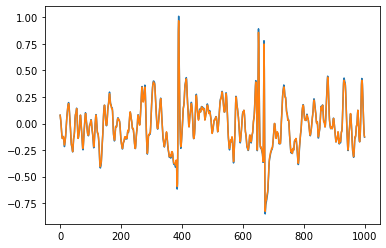

In [22]:
plt.figure()
plt.plot(index_e2005[:1000],data_d102['data'][0][:1000])
plt.plot(index_e2005[:1000],np.array(spikes_d1_rs_802[:1000])/(2**6))
plt.show()
## data_resolution-2

In [23]:
converg = 20
scaling = 1/2048
cnt = 0
data = spikes_e2_rs_701
sigma = 0
sigma_reg = [0]
for i in range(5000):
    for j in range(256):
        if (data[j+i*256] >= sigma):
            cnt+=1
    diff = cnt - converg
    cnt = 0
    sigma = sigma + diff * scaling
    sigma_reg.append(sigma)

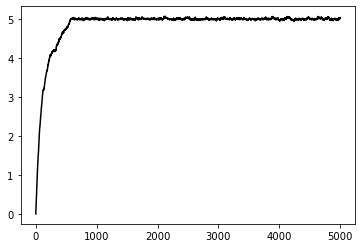

In [24]:
plt.figure()
plt.plot(index_e1005[:5000],sigma_reg[:5000],color = 'black')
# scatter([x for x, y in peaks2s[600:]], [y for x, y in peaks2s[600:]], color = 'red')
#scatter(spike_times[-2], y[-2], color = 'red')
# plt.xlabel('time interval(41.7us/sample)')
# plt.ylabel('microvolts (uV)')
#plt.title("detected points")
#plt.savefig('detections.jpg',dpi=400, transparent=True)
plt.show()

### spike detection
#### NEO + threshold

In [25]:
C0 = 12 #scaling parameter for calculation threshold
for w in ['015']:
    for i in ['3','4','5','6','7','8','10']:
        for j in ['e1','e2','d1','d2']:
            names['neo_value_'+str(j)+'_rs_'+str(i)+str(w)] = neofilter(names['spikes_'+str(j)+'_rs_'+str(i)+str(w)],names['index_'+str(j)+str(w)])
            names['threshold_'+str(j)+'_rs_'+str(i)+str(w)] = C0 * 1/len(names['neo_value_'+str(j)+'_rs_'+str(i)+str(w)]) * sum(names['neo_value_'+str(j)+'_rs_'+str(i)+str(w)])
            names['peaks_neo_tradit_'+str(j)+'_rs_'+str(i)+str(w)] = spikedet(names['neo_value_'+str(j)+'_rs_'+str(i)+str(w)], names['threshold_'+str(j)+'_rs_'+str(i)+str(w)])
            names['detections_neo_'+str(j)+'_rs_'+str(i)+str(w)] = spikefilter(names['peaks_neo_tradit_'+str(j)+'_rs_'+str(i)+str(w)],18)

In [26]:
for w in ['015']:
    for i in ['3','4','5','6','7','8','10']:
        names['DA_neo_e1'+str(i)+str(w)],names['miss_neo_e1'+str(i)+str(w)] = dacalculation(names['data_e1'+str(w)]['spike_times'][0][0][0],names['detections_neo_e1_rs_'+str(i)+str(w)])
        names['DA_neo_e2'+str(i)+str(w)],names['miss_neo_e2'+str(i)+str(w)] = dacalculation(names['data_e2'+str(w)]['spike_times'][0][0][0],names['detections_neo_e2_rs_'+str(i)+str(w)])
        names['DA_neo_d1'+str(i)+str(w)],names['miss_neo_d1'+str(i)+str(w)] = dacalculation(names['data_d1'+str(w)]['spike_times'][0][0][0],names['detections_neo_d1_rs_'+str(i)+str(w)])
        names['DA_neo_d2'+str(i)+str(w)],names['miss_neo_d2'+str(i)+str(w)] = dacalculation(names['data_d2'+str(w)]['spike_times'][0][0][0],names['detections_neo_d2_rs_'+str(i)+str(w)])

In [27]:
for w in ['015']:
    for i in ['3','4','5','6','7','8','10']:
        names['DA_neo'+str(i)+str(w)] = (names['DA_neo_e1'+str(i)+str(w)]+names['DA_neo_e2'+str(i)+str(w)]+names['DA_neo_d1'+str(i)+str(w)]+names['DA_neo_d2'+str(i)+str(w)])/4
        #names['miss_neo'+str(i)+str(w)] = (names['miss_neo_e2'+str(i)+str(w)]+names['miss_neo_d1'+str(i)+str(w)]+names['miss_neo_d2'+str(i)+str(w)])/3

In [28]:
for i in ['3','4','5','6','7','8','10']:
         names['DA_neo'+str(i)] = names['DA_neo'+str(i)+'015']

## Spike Sorting

In [29]:
class Osorter:
    def __init__(self,distance,threshold,update):
        self.distance = distance
        self.threshold= threshold
        self.cluster_means=[]
        self.cluster_cardinality = []
        self.update=update
    
    def closest_cluster(self,signal,test=False):
        min_dist= float("inf")
        for i,center in enumerate(self.cluster_means):
            if(self.cluster_cardinality[i]==-1):
                continue
            if(test and self.cluster_cardinality[i]<np.sum(self.cluster_cardinality)*0.05):
                continue
            dist = self.distance(signal,center)
            if(dist<min_dist):
                min_dist=dist
                ind= i
        if(test):
            try:
                return ind
            except:
                return -1
        if(min_dist<self.threshold):
            return ind
        else:
            return len(self.cluster_means)
        
    def train(self,signal,test=False):
        if(len(self.cluster_means)==0):
            self.cluster_means.append(signal)
            self.cluster_cardinality.append(1)
            return 0
        cluster = self.closest_cluster(signal,test)
        if(cluster==len(self.cluster_means)):
            self.cluster_means.append(signal)
            self.cluster_cardinality.append(1)
            return cluster
        self.cluster_cardinality[cluster]=self.cluster_cardinality[cluster]+1
        self.cluster_means[cluster] =self.update(self.cluster_cardinality[cluster],self.cluster_means[cluster],signal)       
                

        return cluster
    def get_centroids(self):
        return self.cluster_means
        
                
        

In [30]:
exact_update = lambda card,mean,signal:  ((card-1) * mean + signal)/card
approx_update = lambda card,mean,signal: mean + (-mean + signal)/2**(np.ceil(max(np.log2(card+1),256)))

In [31]:
from sklearn.metrics import fowlkes_mallows_score
import itertools
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from coclust.evaluation.external import accuracy

C:\Users\morta\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [32]:
def thresh_calc(sigma,i):
    return (-1/64 + 13 * sigma/32)*factor(i)
factor = lambda i: 24/int(i)+1 if int(i)!=24 else 1

In [33]:
def feature_extraction(signal,fac):
    fd = np.diff(signal)
    sd = np.diff(fd)
    rankfd = np.argsort(fd)
    ranksd=np.argsort(sd)
    return np.array([min(fd),max(fd),min(sd),max(sd),np.argmax(signal)*3*fac/64])



In [34]:
def l1(x,y):
    return  np.linalg.norm(x-y,ord=1)
def l2(x,y):
    return  np.linalg.norm(x-y,ord=2)**2


In [35]:
def hypertune(params,datas,gts,update,merging=False):
    keys, values = zip(*params.items())
    permutations_dict = [dict(zip(keys, v)) for v in itertools.product(*values)]
    max_score = 0
    for param in tqdm(permutations_dict):
        score = 0
        for i in range(len(datas)):
            data = datas[i]
            gt= gts[i]
            X_train, X_test, y_train, y_test = train_test_split(data, gt, test_size=0.2,shuffle=True)
            sorter = Osorter(param['distance'],param['thresh'],update)
            c_hat = np.array([sorter.train(x) for x in X_train])
            c_hat = np.array([sorter.train(x,test=True) for x in X_test])
            score += accuracy(y_test,c_hat)
        
        if score>max_score and (-1) not in set(c_hat):
            best_sorter = sorter
            max_score = score
            best_param = param
            best_pred= c_hat
            
    rng = range(len(X_test[0]))
    colors= ['r','b','g','y','w','k','c','m']
    color_dict={}
    i=0
    for v in list(set(best_pred)):
        color_dict[v] = colors[i]
        i+=1
    plt.figure()
    fig,axs = plt.subplots(1,2, figsize=(15, 5))
    for i in range(len(X_test)):
        axs[0].plot(rng,X_test[i],c= color_dict[best_pred[i]],alpha=.1)
        axs[0].set_title('predictions')
    for i in range(len(X_test)):
        axs[1].plot(rng,X_test[i],c='rgbk'[y_test[i]-1],alpha=.1)
        axs[1].set_title('groud truth')
    plt.show()
    print(best_param,max_score/len(datas))
    return best_param,max_score/len(datas)

In [36]:
def train_predict(param,data,gt,update,merging=False):


    X_train, X_test, y_train, y_test = train_test_split(data, gt, test_size=0.2,shuffle=True)
    sorter = Osorter(param['distance'],param['thresh'],update)
    c_hat = np.array([sorter.train(x) for x in X_train])
    c_hat = np.array([sorter.train(x,test=True) for x in X_test])
    score = accuracy(y_test,c_hat)
    
    return score

In [37]:
fact = 24
best_params = []
best_scores = []
noise = [0.05,0.1,0.15,0.2]
thresholds = (np.array(noise)*0.2990+0.019)
for ind,w in enumerate(tqdm(['005','01','015','02'])):
    best_params_res= []
    for t,i in enumerate(tqdm(['3','4','5','6','7','8','10'])):
        resolution_res = []
        for j in ['e1','e2','d1','d2']:
            spike_times = names['data_'+j+str(w)]['spike_times'][0][0][0]
            signal = np.array(names['spikes_'+str(j)+'_rs_'+str(i)+str(w)])/(2**(int(i)-2))
            sigma = np.std(signal)
            signals = list(map(lambda x: signal[x+15:x+40],spike_times))
            features= [feature_extraction(signal,factor('24')) for signal in signals]
            gt = names['data_'+j+str(w)]['spike_class'][0][0][0]
            scores = []
            l1_params ={
                'distance':l2,
                'thresh':thresh_calc(sigma,'24'),
            }
            for loop in range(20):
                l1_score = train_predict(l1_params,features,gt,approx_update,False)
                print(l1_score)
                scores.append(l1_score)
            resolution_res.append(scores)

        best_params_res.append(resolution_res)
    best_scores.append(best_params_res)

C:\Users\morta\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


0.6600284495021337
0.65149359886202
0.647226173541963
0.6770981507823614
0.6799431009957326
0.6827880512091038
0.6884779516358464
0.7254623044096729
0.7069701280227596
0.6500711237553343
0.6401137980085349
0.6671408250355618
0.6401137980085349
0.6116642958748222
0.6827880512091038
0.5305832147937412
0.6557610241820768
0.6927453769559033
0.7041251778093883
0.662873399715505
0.7727272727272727
0.7316715542521994
0.7727272727272727
0.7903225806451613
0.7302052785923754
0.7917888563049853
0.7258064516129032
0.7375366568914956
0.7214076246334311
0.7595307917888563
0.7668621700879765
0.7287390029325513
0.7624633431085044
0.7419354838709677
0.7844574780058651
0.7551319648093842
0.7888563049853372
0.7741935483870968
0.7609970674486803
0.7609970674486803
0.4874446085672083
0.4771048744460857
0.42688330871491875
0.4298375184638109
0.4667651403249631
0.4357459379615953
0.4505169867060561
0.46824224519940916
0.4505169867060561
0.4534711964549483
0.43722304283604135
0.4254062038404727
0.45790251107

0.9765395894428153
0.9780058651026393
0.9809384164222874
0.9838709677419355
0.9882697947214076
0.9809384164222874
0.9748892171344166
0.9778434268833087
0.9719350073855244
0.9807976366322009
0.96602658788774
0.8833087149187593
0.9734121122599705
0.9778434268833087
0.9793205317577548
0.9793205317577548
0.982274741506647
0.9807976366322009
0.9763663220088626
0.9556868537666174
0.9748892171344166
0.8862629246676514
0.9763663220088626
0.9807976366322009
0.9748892171344166
0.9807976366322009
0.9777117384843982
0.9851411589895989
0.9836552748885586
0.9881129271916791
0.9806835066864784
0.9955423476968797
0.9881129271916791
0.9806835066864784
0.9836552748885586
0.9836552748885586
0.9881129271916791
0.8855869242199108
0.9851411589895989
0.9881129271916791
0.9836552748885586
0.9821693907875185
0.9762258543833581
0.9895988112927192
0.9881129271916791
0.9777117384843982
0.984352773826458
0.9786628733997155
0.9715504978662873
0.9715504978662873
0.9715504978662873
0.9743954480796586
0.97866287339971

0.64822695035461
0.6794326241134752
0.6879432624113475
0.6978723404255319
0.7021276595744681
0.6836879432624113
0.6865248226950355
0.601418439716312
0.724822695035461
0.7134751773049646
0.7134751773049646
0.6879432624113475
0.723404255319149
0.700709219858156
0.7035460992907802
0.7432624113475177
0.7276595744680852
0.6624113475177305
0.7262411347517731
0.7035460992907802
0.671875
0.6576704545454546
0.6931818181818182
0.6846590909090909
0.671875
0.6988636363636364
0.6676136363636364
0.6761363636363636
0.6818181818181818
0.703125
0.7329545454545454
0.6818181818181818
0.6803977272727273
0.6846590909090909
0.7045454545454546
0.6803977272727273
0.6732954545454546
0.6605113636363636
0.6860795454545454
0.6747159090909091
0.3695652173913043
0.391304347826087
0.4043478260869565
0.3869565217391304
0.3927536231884058
0.3753623188405797
0.37971014492753624
0.39565217391304347
0.37971014492753624
0.391304347826087
0.37971014492753624
0.40144927536231884
0.4028985507246377
0.4043478260869565
0.37101

0.972463768115942
0.9623188405797102
0.9884057971014493
0.9753623188405797
0.981159420289855
0.9710144927536232
0.972463768115942
0.9768115942028985
0.9840579710144928
0.9855072463768116
0.9855072463768116
0.9666666666666667
0.9753623188405797
0.9710144927536232
0.9826086956521739
0.972463768115942
0.9797101449275363
0.9855072463768116
0.9652173913043478
0.987012987012987
0.9841269841269841
0.987012987012987
0.9884559884559885
0.9913419913419913
0.9884559884559885
0.987012987012987
0.98989898989899
0.987012987012987
0.9841269841269841
0.987012987012987
0.987012987012987
0.9927849927849928
0.9956709956709957
0.9927849927849928
0.987012987012987
0.9913419913419913
0.9884559884559885
0.9826839826839827
0.9855699855699855
0.9843971631205674
0.9815602836879432
0.9801418439716312
0.9815602836879432
0.9843971631205674
0.9858156028368794
0.9815602836879432
0.9815602836879432
0.9829787234042553
0.9900709219858156
0.9801418439716312
0.9886524822695035
0.9843971631205674
0.9773049645390071
0.9787

0.6738505747126436
0.7155172413793104
0.507183908045977
0.7112068965517241
0.7097701149425287
0.6982758620689655
0.4899425287356322
0.6997126436781609
0.6594827586206896
0.7140804597701149
0.6939655172413793
0.5244252873563219
0.7126436781609196
0.7126436781609196
0.7126436781609196
0.6594827586206896
0.521551724137931
0.6206896551724138
0.5905172413793104
0.7083333333333334
0.6632503660322109
0.664714494875549
0.6515373352855052
0.6588579795021962
0.6442166910688141
0.6530014641288433
0.6910688140556369
0.6515373352855052
0.6486090775988287
0.6442166910688141
0.6515373352855052
0.6749633967789166
0.6383601756954612
0.6939970717423133
0.6456808199121523
0.6676427525622255
0.6588579795021962
0.6691068814055637
0.6603221083455344
0.6705710102489019
0.4028776978417266
0.42158273381294964
0.3410071942446043
0.3712230215827338
0.4302158273381295
0.40431654676258993
0.4330935251798561
0.46474820143884893
0.3697841726618705
0.4719424460431655
0.46474820143884893
0.36115107913669064
0.38273381

0.8726207906295754
0.9897510980966325
0.986822840409956
0.9795021961932651
0.9323741007194245
0.9741007194244604
0.9697841726618706
0.9726618705035971
0.9165467625899281
0.9064748201438849
0.9151079136690647
0.981294964028777
0.9755395683453237
0.9669064748201439
0.9467625899280575
0.9539568345323741
0.9611510791366906
0.9568345323741008
0.9798561151079137
0.9611510791366906
0.958273381294964
0.9597122302158273
0.9683453237410072
0.935251798561151
0.9825581395348837
0.6540697674418605
0.9709302325581395
0.9840116279069767
0.9898255813953488
0.9723837209302325
0.9752906976744186
0.8648255813953488
0.9869186046511628
0.9869186046511628
0.9113372093023255
0.9840116279069767
0.8604651162790697
0.9840116279069767
0.6366279069767442
0.9898255813953488
0.9738372093023255
0.9811046511627907
0.9752906976744186
0.9709302325581395
0.9741379310344828
0.9885057471264368
0.985632183908046
0.9755747126436781
0.9655172413793104
0.9770114942528736
0.978448275862069
0.9798850574712644
0.978448275862069


0.6115107913669064
0.5093525179856115
0.6028776978417266
0.4244604316546763
0.5179856115107914
0.6776978417266187
0.5223021582733813
0.6201438848920864
0.5640287769784172
0.4546762589928058
0.4316546762589928
0.6776978417266187
0.44028776978417267
0.5223021582733813
0.637410071942446
0.3640287769784173
0.5035971223021583
0.6402877697841727
0.660431654676259
0.4892086330935252
0.6742209631728046
0.6968838526912181
0.6643059490084986
0.7039660056657224
0.6869688385269122
0.6586402266288952
0.6954674220963173
0.6926345609065155
0.6487252124645893
0.6940509915014165
0.6643059490084986
0.6770538243626062
0.6756373937677054
0.6657223796033994
0.7039660056657224
0.6813031161473088
0.6968838526912181
0.7124645892351275
0.71671388101983
0.6643059490084986
0.37920937042459735
0.3762811127379209
0.35724743777452417
0.3953147877013177
0.3484626647144949
0.3513909224011713
0.34699853587115664
0.37481698389458273
0.35724743777452417
0.4055636896046852
0.35871156661786235
0.3938506588579795
0.3601756

0.9872521246458924
0.9830028328611898
0.9830028328611898
0.9844192634560907
0.9844192634560907
0.9886685552407932
0.9815864022662889
0.9801699716713881
0.9385065885797951
0.9267935578330894
0.9428989751098097
0.9575402635431918
0.9326500732064422
0.9121522693997072
0.6676427525622255
0.9004392386530015
0.9458272327964861
0.9546120058565154
0.9238653001464129
0.9604685212298683
0.8125915080527086
0.9575402635431918
0.9004392386530015
0.9355783308931186
0.9516837481698389
0.9575402635431918
0.9531478770131772
0.664714494875549
0.8626609442060086
0.9356223175965666
0.9055793991416309
0.9699570815450643
0.8698140200286123
0.7682403433476395
0.8955650929899857
0.9427753934191703
0.9914163090128756
0.8669527896995708
0.9628040057224606
0.9828326180257511
0.8741058655221745
0.9814020028612304
0.977110157367668
0.9527896995708155
0.9599427753934192
0.9456366237482118
0.9785407725321889
0.9685264663805436
0.9755395683453237
0.9784172661870504
0.9697841726618706
0.9683453237410072
0.975539568345

In [38]:
values = np.mean(np.array
                 (best_scores),axis=3)[1]
stes = (np.std(np.array(best_scores)*100,axis=3).T/np.sqrt(20))[1]
stes

array([[0.50088929, 0.37386231, 0.32397883, 0.41623543],
       [1.20290359, 0.81748825, 0.68861546, 0.44562446],
       [2.23647838, 2.57927862, 2.04578346, 2.33320721],
       [1.67498731, 0.89707637, 0.82813766, 0.87124299],
       [0.08674604, 0.51778199, 0.07925252, 0.08227194],
       [0.08935564, 0.09260231, 0.55719673, 0.68055031],
       [0.22539667, 0.22445879, 0.76908585, 0.41397592]])

In [39]:
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"

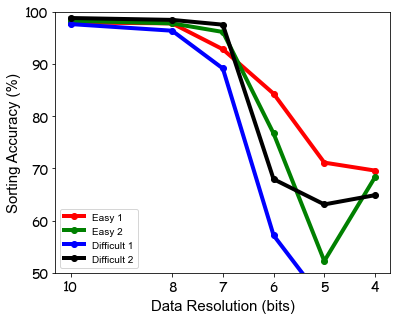

In [45]:
plt.figure(figsize=(6,4.8))
resolutions= [4,5,6,7,8,10]
titles = ['Easy 1','Easy 2', 'Difficult 1','Difficult 2']

for i in range(4):
    plt.plot(resolutions,values[:-1,i]*100,color = 'rgbk'[i],marker='o',markersize=6,linewidth = '4',label=titles[i])
plt.ylim(50,100)
plt.gca().invert_xaxis()
plt.xticks(resolutions,size = 14)
plt.yticks(size = 14)
plt.xlabel('Data Resolution (bits)',fontsize=15,fontname="Arial")
plt.ylabel('Sorting Accuracy (%)',fontsize=15,fontname="Arial")
plt.legend(loc='lower left',prop={'family': 'Arial'})
plt.savefig('ResolutionVSAccuracy.png',dpi=400, transparent=True,bbox_inches = 'tight')


Text(0.5, 0.98, 'Sorting Accuracy')

<Figure size 432x288 with 0 Axes>

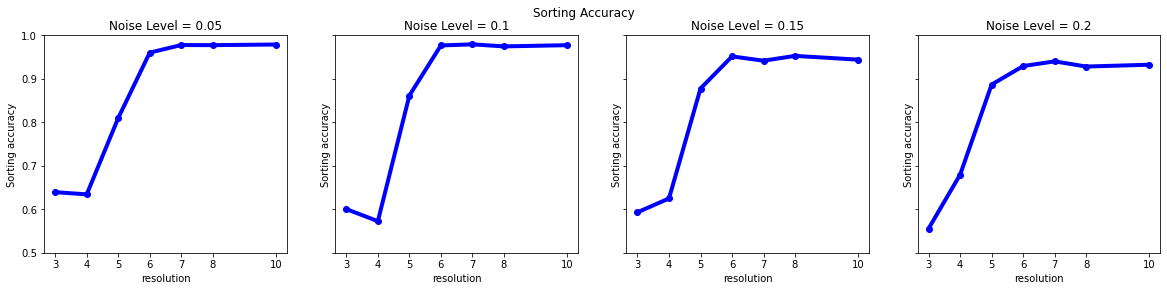

In [41]:
plt.figure()
fig,axs = plt.subplots(1,len(means), figsize=(20, 4),sharey=True)
res = [3,4,5,6,7,8,10]
titles = ['data E1','data E2', 'data D1','data D2']
for i in range(len(means)):
    axs[i].plot(res,means[i],color = 'blue',marker='o',markersize=6,linewidth = '4')
    axs[i].set_ylim(0.5,1)
    axs[i].set_xticks(res)
    axs[i].set_xlabel('resolution')
    axs[i].set_ylabel('Sorting accuracy')
    axs[i].set_title('Noise Level = '+str(noise[i]))
fig.suptitle('Sorting Accuracy')

In [45]:
np.mean(means,axis=0)

array([0.59720556, 0.6279661 , 0.85902728, 0.95452189, 0.95975523,
       0.95830715, 0.95824094])